# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [4]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [5]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [6]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [8]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [9]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [10]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [11]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [34]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
#     numerator = (TP+TN)
#     denominator = (TP+TN+FP+FN)
    fitness = TP / (TP+FN)

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [35]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.821
P_MUTATION = 0.03
ELITE_SIZE = round(0.02*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 18
MIN_INIT_TREE_DEPTH = 10
MAX_TREE_DEPTH = 28
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [36]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=3)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [37]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std     	min	max	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.510585	0.322963	0  	1  	0           	241            	731.51    	2937      	0             	9.50769        
1  	166    	0.436571	0.364163	0  	1  	1           	319            	659.715   	2937      	0.000843048   	4.80019        
2  	29     	0.626422	0.378482	0  	1  	1           	319            	392.355   	1289      	0.000846148   	3.96784        
3  	12     	0.710593	0.357909	0  	1  	1           	319            	383.25    	1017      	0.000837803   	3.92754        
4  	3      	0.889736	0.269283	0  	1  	1           	319            	371.64    	994       	0.000829935   	3.79189        
5  	2      	0.932327	0.229499	0  	1  	1           	319            	372.33    	995       	0.000822067   	3.69718        
6  	1      	0.967024	0.165487	0  	1  	1           	319            	373.205   	994       	0.00194287    	3.68136        
7  	1      	0.958705	0.183583	0  	1  	1 

68 	0      	0.944981	0.223555	0  	1  	1           	319            	144.33    	516       	0.000827074   	2.86935        
69 	0      	0.954647	0.192849	0  	1  	1           	319            	133.71    	516       	0.00129104    	2.64431        
70 	0      	0.945977	0.208544	0  	1  	1           	319            	146.325   	515       	0.0008111     	2.81698        
71 	1      	0.951933	0.209341	0  	1  	1           	319            	135.86    	515       	0.000819206   	2.9351         
72 	1      	0.961041	0.179502	0  	1  	1           	319            	136.395   	515       	0.000854015   	3.01469        
73 	0      	0.953021	0.199171	0  	1  	1           	319            	131.575   	510       	0.00085187    	2.96802        
74 	1      	0.965643	0.179101	0  	1  	1           	319            	133.235   	510       	0.000833988   	3.06686        
75 	0      	0.960117	0.190948	0  	1  	1           	319            	128.445   	510       	0.000818014   	3.15557        
76 	0      	0.964342	0.171806	0  	1  	1 

**Statistics**

In [38]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.510585,0.322963,0.0,1.0,0.0,241,731.510,2937,0.000000,9.507687
1,1,166,0.436571,0.364163,0.0,1.0,1.0,319,659.715,2937,0.000843,4.800186
2,2,29,0.626422,0.378482,0.0,1.0,1.0,319,392.355,1289,0.000846,3.967843
3,3,12,0.710593,0.357909,0.0,1.0,1.0,319,383.250,1017,0.000838,3.927544
4,4,3,0.889736,0.269283,0.0,1.0,1.0,319,371.640,994,0.000830,3.791886
5,5,2,0.932327,0.229499,0.0,1.0,1.0,319,372.330,995,0.000822,3.697179
6,6,1,0.967024,0.165487,0.0,1.0,1.0,319,373.205,994,0.001943,3.681362
7,7,1,0.958705,0.183583,0.0,1.0,1.0,319,391.585,997,0.000877,3.732520
8,8,2,0.967872,0.172099,0.0,1.0,1.0,319,389.640,994,0.001765,3.630451
9,9,0,0.974288,0.153679,0.0,1.0,1.0,319,350.420,912,0.000855,3.779871


**Best individual**

In [39]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
x[2]

Training Fitness:  1.0

Depth:  2

Length of the genome:  319

Used portion of the genome: 0.00



Testing best individual

In [40]:
x = X_test
def get_confusion_matrix(Y_labels, Y_predictions):
    TP, FN, TN, FP = 0, 0, 0, 0
    for x, y in zip(Y_labels, Y_predictions):
      if x == 0:
        if y == 0:
          TN = TN + 1
        else:
          FP = FP + 1
      elif x == 1:
        if y == 1:
          TP = TP + 1
        else:
          FN = FN + 1
    return TP, FN, TN, FP

In [45]:
predictions = x[2]
print("Predictions ", predictions)
print()

Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print("Labels", Counter(Y_prediction_class))
print()

print("************ Fitness Metrics ************")
print()

TP, FN, TN, FP = get_confusion_matrix(Y_test, Y_prediction_class)
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
print("Accuracy:             ", accuracy)
print()

TPR = TP/(TP+FN)
print("True positive rate:   ", TPR)
print()

TNR = TN/(TN+FP)
print("True negative rate:   ", TNR)
print()

FPR = FP/(FP+TN)
print("False positive rate:  ", FPR)
print()

FNR = FN/(FN+TP)
print("False negative rate:  ", FNR)
print()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
print("Area under the curve: ", auc)

Predictions  [0.16927359 3.8881429  3.58684772 ... 0.98464839 4.26029948 3.819907  ]

Labels Counter({1: 14261, 0: 150})

************ Fitness Metrics ************

Accuracy:              0.510374019845951

True positive rate:    1.0

True negative rate:    0.020815986677768527

False positive rate:   0.9791840133222315

False negative rate:   0.0

Area under the curve:  0.5104079933388843


**Best individuals plots**

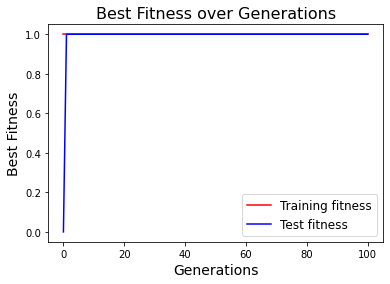

In [49]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()

**Average fitness plot**

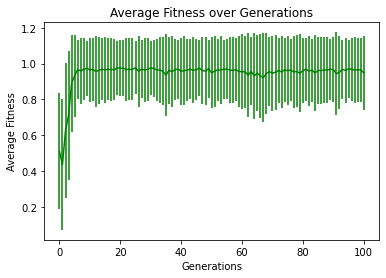

In [47]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

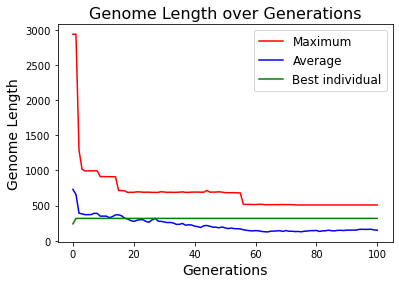

In [48]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()